In [1]:
## Build Data set
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader
import torch.nn.functional as F


In [2]:
os.chdir('../')
os.getcwd()

'/Users/markbrackenrig/Documents/2021_FEB/ADSI/assignment_2'

In [3]:
from src.data import make_dataset

In [4]:
data = pd.read_csv('data/raw/beer_reviews.csv')
subsample = data.sample(frac=0.5, random_state = 1)

In [5]:
X,y,y_encoder,ohe,scaler = make_dataset.process_data(subsample,2500)

columns dropped
brewery names encoded
scaled data


In [6]:
subsample.head(5)

,review_aroma,review_appearance,beer_style,review_palate,review_taste
1480069,4.0,4.5,Hefeweizen,4.0,4.0
29298,4.5,4.0,American Double / Imperial IPA,4.5,4.0
727274,2.0,2.0,English India Pale Ale (IPA),2.0,2.5
134051,4.5,5.0,American Double / Imperial IPA,4.0,4.5
77099,4.0,4.0,American Barleywine,4.5,4.0


## Split into training and test sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.25, random_state = 42)

In [9]:
from src.models.pytorch import PytorchDataset

train_dataset = PytorchDataset(X=X_train, y=y_train)
val_dataset = PytorchDataset(X=X_val, y=y_val)
test_dataset = PytorchDataset(X=X_test, y=y_test)

## Define Baseline Model

In [10]:
from src.models.null import NullModel

baseline_model = NullModel(target_type = 'classification')
y_base = baseline_model.fit_predict(y_train)

In [11]:
from src.models.performance import print_class_perf
print_class_perf(y_base, y_train, set_name='Training', average = 'weighted')

Accuracy Training: 0.07396902830563276
F1 Training: 0.010189152581265001


## Define Model Architecture

Just want to get a basic 1 layer model working before I try and get anything deeper working

In [12]:
from src.models.pytorch import PytorchMultiClass

model = PytorchMultiClass(num_features = X_train.shape[1],class_num= 104)

In [13]:
class PytorchMultiClass(nn.Module):
    def __init__(self, num_features,class_num):
        super(PytorchMultiClass, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 104)
        self.layer_out = nn.Linear(104,class_num)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.dropout(F.relu(self.layer_1(x)), training=self.training)
        x = self.layer_out(x)
        return self.softmax(x)
    
    
model = PytorchMultiClass(num_features = X_train.shape[1],class_num= 104)

In [14]:
from src.models.pytorch import get_device
device = get_device()
print(device)
model.to(device)

cpu


PytorchMultiClass(
  (layer_1): Linear(in_features=2504, out_features=104, bias=True)
  (layer_out): Linear(in_features=104, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
)

## Train Model

In [15]:
N_EPOCHS = 30
BATCH_SIZE = 10000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [16]:
from src.models.train_model import train_classification, test_classification

In [17]:
tr_losses = []
val_losses = []
tr_acc = []
val_acc = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_classification(train_dataset, model=model, criterion=criterion, optimizer=optimizer, batch_size=BATCH_SIZE, device=device)
    valid_loss, valid_acc = test_classification(val_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)
    tr_losses.append(train_loss)
    val_losses.append(valid_loss)
    tr_acc.append(train_acc)
    val_acc.append(valid_acc)
    print(f'Epoch: {epoch}')
    print(f'\t(train)\t|\tLoss: {train_loss:.4f}\t|\tAcc: {train_acc * 100:.1f}%')
    print(f'\t(valid)\t|\tLoss: {valid_loss:.4f}\t|\tAcc: {valid_acc * 100:.1f}%')

Epoch: 0: |████████████████████████████████████████████████--| 97.9% Complete
	(train)	|	Loss: 0.0005	|	Acc: 13.4%
	(valid)	|	Loss: 0.0005	|	Acc: 17.2%
Epoch: 1: |████████████████████████████████████████████████--| 97.9% Complete
	(train)	|	Loss: 0.0005	|	Acc: 18.2%
	(valid)	|	Loss: 0.0005	|	Acc: 19.7%
Epoch: 2: |████████████████████████████████████████████████--| 97.9% Complete
	(train)	|	Loss: 0.0004	|	Acc: 20.4%
	(valid)	|	Loss: 0.0004	|	Acc: 21.9%
Epoch: 3: |████████████████████████████████████████████████--| 97.9% Complete
	(train)	|	Loss: 0.0004	|	Acc: 21.5%
	(valid)	|	Loss: 0.0004	|	Acc: 22.2%
Epoch: 4: |████████████████████████████████████████████████--| 97.9% Complete
	(train)	|	Loss: 0.0004	|	Acc: 21.8%
	(valid)	|	Loss: 0.0004	|	Acc: 22.3%
Epoch: 5: |████████████████████████████████████████████████--| 97.9% Complete
	(train)	|	Loss: 0.0004	|	Acc: 21.9%
	(valid)	|	Loss: 0.0004	|	Acc: 22.3%
Epoch: 6: |████████████████████████████████████████████████--| 97.9% Complete
	(train)	|

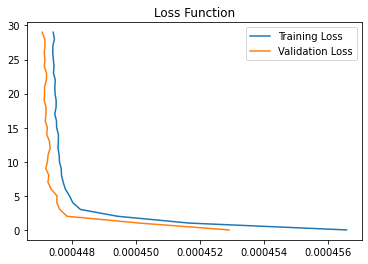

In [28]:
import matplotlib.pyplot as plt
plt.plot(tr_losses, range(N_EPOCHS), label = "Training Loss")
plt.plot(val_losses, range(N_EPOCHS), label = "Validation Loss")
plt.title('Loss Function')
plt.legend()

In [19]:

def predict(test_data, model, criterion, batch_size, device, generate_batch=None):
    """Calculate performance of a Pytorch multi-class classification model

    Parameters
    ----------
    test_data : torch.utils.data.Dataset
        Pytorch dataset
    model: torch.nn.Module
        Pytorch Model
    criterion: function
        Loss function
    bacth_size : int
        Number of observations per batch
    device : str
        Name of the device used for the model
    collate_fn : function
        Function defining required pre-processing steps

    Returns
    -------
    Float
        Loss score
    Float:
        Accuracy Score
    """    
    
    # Set model to evaluation mode
    model.eval()
    test_loss = 0
    test_acc = 0
    
    # Create data loader
    data = DataLoader(test_data, batch_size=batch_size, collate_fn=generate_batch)
    results = []
    # Iterate through data by batch of observations
    for feature, target_class in data:
        
        feature, target_class = feature.to(device), target_class.flatten().to(device)
        
        # Set no update to gradients
        with torch.no_grad():
            # Make predictions
            output = model(feature)
            
        results.append({'prediction': output.argmax(1)[0],'target': target_class[0] })
    return results

In [20]:
test_predictions = predict(test_dataset, model=model, criterion=criterion, batch_size=1, device=device)

In [21]:
test_predictions = pd.DataFrame(test_predictions)

In [22]:
test_predictions.head(4)

,prediction,target
0,tensor(12),tensor(101.)
1,tensor(12),tensor(12.)
2,tensor(89),tensor(89.)
3,tensor(11),tensor(84.)


In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
pd.DataFrame(confusion_matrix(test_predictions['prediction'].astype(int), test_predictions['target'].astype(int))).to_csv('reports/confusion_matrix.csv')

In [25]:
acc = 100*sum(np.where(test_predictions["prediction"]==test_predictions["target"],1,0))/len(test_predictions)
print("Accuracy: "+str(acc)+"%")

Accuracy: 22.268091918669878%


## Save Model

In [29]:
import pickle as pkl

pkl.dump(ohe, open('models/ohe.pkl', 'wb'))
pkl.dump(y_encoder, open('models/y_encoder.pkl', 'wb'))
pkl.dump(scaler, open('models/scaler.pkl', 'wb'))

torch.save(model.state_dict(), "models/beer_style_prediction.pt")